Entropic Regularization of Optimal Transport
============================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.

This numerical tours exposes the general methodology of regularizing the
optimal transport (OT) linear program using entropy. This allows to
derive fast computation algorithm based on iterative projections
according to a Kulback-Leiber divergence.

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

from numpy import linalg

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import random

Entropic Regularization of Optimal Transport
--------------------------------------------
We consider two input histograms $a,b \in \Sigma_n$, where we denote the simplex in $\mathbb{R}^n$
$$ \Sigma_n := \left\{ a \in \mathbb{R}_+^n \mid \sum_i a_i = 1 \right\}.  $$
We consider the following discrete regularized transport
$$  W_\epsilon(a,b) := \min\limits_{P \in U(a,b)} \langle C, P \rangle - \epsilon E(P).  $$
where the polytope of coupling is defined as
$$ U(a,b) := \left\{P \in (\mathbb{R}^+)^{n \times m} \mid P \mathbf{1}_m = a, P^\top \mathbf{1}_n = b \right\},  $$
where $\mathbf{1}_n := (1,\ldots,1)^\top \in \mathbb{R}^n $,
and for $P \in \mathbb{R}_+^{n \times m}$, we define its entropy as
$$ E(P) := -\sum_{i,j} P_{i,j} ( \log(P_{i,j}) - 1). $$


When $\epsilon=0$ one recovers the classical (discrete) optimal transport.
We refer to the monograph [Villani](#biblio) for more details about OT.
The idea of regularizing transport to allows for faster computation is
introduced in [Cuturi](#biblio).


Here the matrix $C \in (\mathbb{R}^+)^{n \times m} $ defines the ground cost, i.e.
$C_{i,j}$ is the cost of moving mass from a bin indexed by $i$ to a bin indexed by $j$.


The regularized transportation problem can be re-written as a projection
$$ W_\epsilon(a,b) = \epsilon \min\limits_{P \in U(a,b)} \text{KL}(P \mid K)
	\text{ where }
	K_{i,j} := e^{ -\frac{C_{i,j}}{\epsilon} }  $$
of the Gibbs kernel $K$ according to the Kullback-Leibler divergence.
The Kullback-Leibler divergence between $P, K \in \mathbb{R}_+^{n \times m}$ is
$$ \text{KL}(P \mid K) := \sum_{i,j} P_{i,j} \left( \log \left( \frac{P_{i,j}}{K_{i,j}} \right) - 1\right). $$


This interpretation of regularized transport as a KL projection and its numerical
applications are detailed in [BenamouEtAl](#biblio).


Given a convex set $\mathcal{C} \subset \mathbb{R}^N$, the projection according to the Kullback-Leiber divergence is defined as
$$ \text{Proj}^{\text{KL}}_\mathcal{C}(\xi) = \underset{ \pi \in \mathcal{C}}{\text{argmin }} \text{KL}(\pi \mid \xi). $$

Iterative Bregman Projection Algorithm
--------------------------------------
Given affine constraint sets $ (\mathcal{C}_1,\mathcal{C}_2) $, we aim at computing
$$   \text{Proj}^{\text{KL}}_\mathcal{C}(K) \text{ where } \mathcal{C} = \mathcal{C}_1 \cap \mathcal{C}_2 $$
(this description can of course be extended to more than 2 sets). 

This can be achieved, starting by $P_0=K$, by iterating $\forall \ell \geq 0$, 
$$ P_{2\ell+1} = \text{Proj}^{\text{KL}}_{\mathcal{C}_1}(P_{2\ell})
 \text{ and } 
  P_{2\ell+2} =  \text{Proj}^{\text{KL}}_{\mathcal{C}_2}(P_{2\ell+1}). $$

One can indeed show that $P_\ell \rightarrow \text{Proj}^{\text{KL}}_\mathcal{C}(K)$.
We refer to [BauschkeLewis](#biblio) for more details about this
algorithm and its extension to compute the projection on the intersection of
convex sets (Dikstra algorithm).

Sinkhorn's Algorithm
-----------------------------------------------------------------------

A fundamental remark is that the optimality condition of the entropic regularized problem shows that the optimal coupling $P_\epsilon$ necessarily has the form 
$$P_\epsilon = \text{diag}(u) K \text{diag}(v)$$
where the Gibbs kernel is defined as
$$K := e^{-\frac{C}{\epsilon}}.$$

One thus needs to find two positive scaling vectors $u \in \mathbb{R}_+^n$ and $v \in \mathbb{R}_+^m$ such that the two following equality holds
$$P \mathbf{1}  = u \odot (K v) = a 
\text{ and }
P^\top \mathbf{1}  = v \odot (K^\top u) = b.$$

Sinkhorn's algorithm alternate between the resolution of these two equations, and reads
$$u \longleftarrow \frac{a}{K v} \text{ and } v \longleftarrow \frac{b}{K^\top u}.$$
This algorithm was shown to converge to a solution of the entropic regularized problem by [Sinkhorn](#biblio).

Transport Between Point Clouds
------------------------------
We first test the method for two input measures that are uniform measures
(i.e. constant histograms) supported on two point clouds
(that do not necessarily have the same size).


We thus first load two points clouds $x=(x_i)_{i=1}^{n}, y=(y_i)_{i=1}^{m}, $
where $x_i, y_i \in \mathbb{R}^2$.


Number of points in each cloud, $N=(n,m)$.

In [3]:
N = [80,160]

Dimension of the clouds.

In [4]:
d = 2

Point clouds.

In [5]:
def sample_annulus(x0, y0, r, R):
    x = 0
    y = 0
    cnd = True
    while cnd:
        phi = 2.0 * math.pi * random.random()
        rad = R * math.sqrt(random.random())
        x = rad * math.cos(phi)
        y = rad * math.sin(phi)
        cnd = ( x**2 + y**2 < r**2 )
    return (x + x0,y + y0)

In [6]:
x = np.array([sample_annulus(0,0,0.5,0.7) for i in range(N[0])]).T
y = np.concatenate([np.array([sample_annulus(0,0, 0,0.4) for i in range(int(N[1]/4))]), np.array([sample_annulus(0,0,0.8,1) for i in range(3*int(N[1]/4))])]).T

Shortcut for displaying point clouds.

In [7]:
plotp = lambda x,col: plt.scatter(x[0,:], x[1,:], s=200, edgecolors="k", c=col, linewidths=1)

Display of the two clouds.

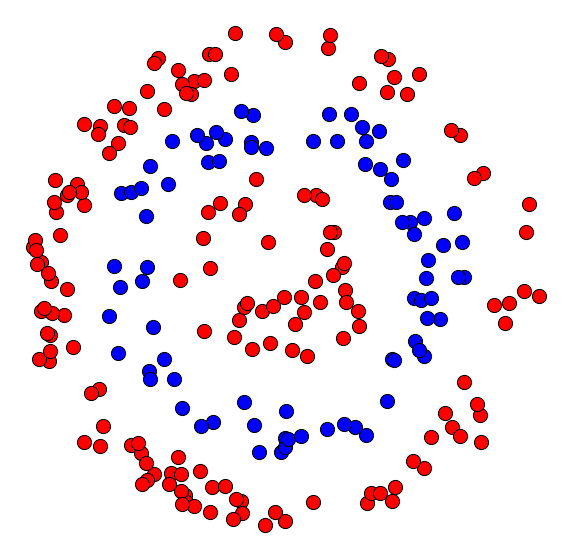

In [8]:
plt.figure(figsize=(10,10))

plotp(x, 'b')
plotp(y, 'r')

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)
# plt.xlim(-6,6)
# plt.ylim(-5,2)

plt.show()

Cost matrix $C_{i,j} = \lVert x_i-y_j \rVert ^2$.

In [9]:
x2 = np.sum(x**2,0)
y2 = np.sum(y**2,0)
C = np.tile(y2,(N[0],1)) + np.tile(x2[:,np.newaxis],(1,N[1])) - 2*np.dot(np.transpose(x),y)

Target histograms $(a,b)$, here uniform histograms.

In [10]:
a = np.ones(N[0])/N[0]
b = np.ones(N[1])/N[1]

Regularization strength $\epsilon>0$.

In [11]:
epsilon = .01

Gibbs Kernel $K$.

In [12]:
K = np.exp(-C/epsilon)

Initialization of $v=\mathbf{1}_{m}$ ($u$ does not need to be
initialized).

In [13]:
v = np.ones(N[1])

One sinkhorn iteration.

In [14]:
u = a / (np.dot(K,v))
v = b / (np.dot(np.transpose(K),u))

__Exercise 1__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$$ \lVert P \mathbf{1} - a \rVert_1 \text{ and } \lVert P^\top \mathbf{1} - b \rVert $$
(you need to think about how to compute these residuals from $(u,v)$ alone).
isplay the violation of constraint error in log-plot.

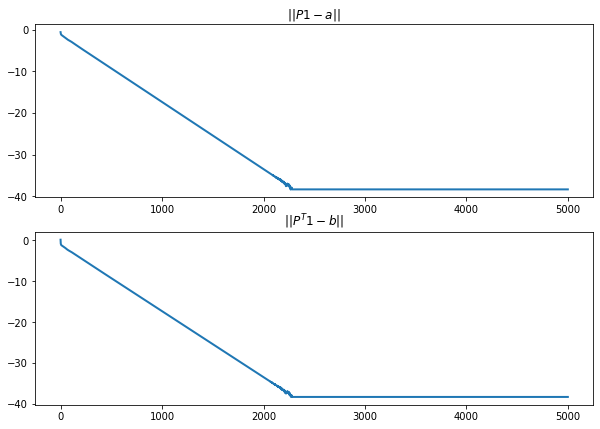

In [15]:
epsilon = .01
K = np.exp(-C/epsilon)

v = np.ones(N[1])
niter = 5000
Err_p = []
Err_q = []

for i in range(niter):
    # sinkhorn step 1
    u = a / (np.dot(K,v))
    # error computation
    r = v*np.dot(np.transpose(K),u)
    Err_q = Err_q + [linalg.norm(r - b, 1)]
    # sinkhorn step 2
    v = b /(np.dot(np.transpose(K),u))
    s = u*np.dot(K,v)
    Err_p = Err_p + [linalg.norm(s - a,1)]

plt.figure(figsize = (10,7))

plt.subplot(2,1,1)
plt.title("$||P 1 - a||$")
plt.plot(np.log(np.asarray(Err_p)), linewidth = 2)

plt.subplot(2,1,2)
plt.title("$||P^T 1 - b||$")
plt.plot(np.log(np.asarray(Err_q)), linewidth = 2)

plt.show()

Compute the final matrix $P$.

In [16]:
P = np.dot(np.dot(np.diag(u),K),np.diag(v))

Display it.

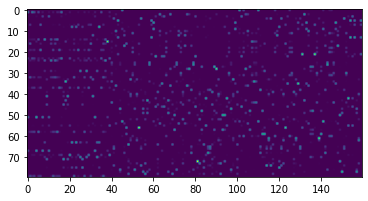

In [17]:
plt.imshow(P);

__Exercise 2__

Display the regularized transport solution for various values of $\epsilon$.
For a too small value of $\epsilon$, what do you observe ?

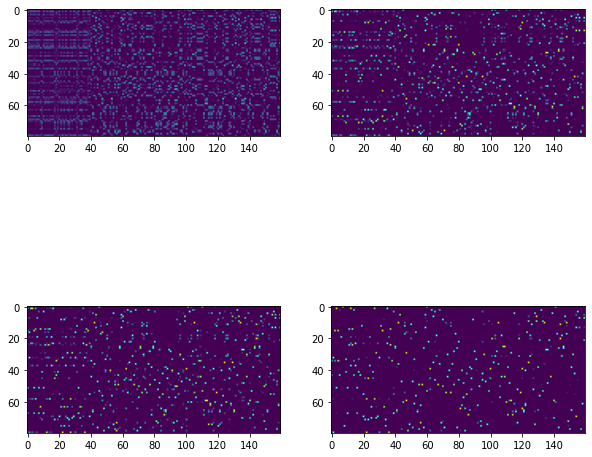

In [18]:
plt.figure(figsize = (10,10))
glist = [.1,.01,.005,.001]
niter = 300

clamp = lambda x,a,b: min(max(x,a),b)

for k in range(len(glist)):
    epsilon = glist[k]
    K = np.exp(-C/epsilon)
    v = np.ones(N[1])

    for i in range(niter):
        u = a / (np.dot(K,v))
        v = b /(np.dot(np.transpose(K),u))

    P = np.dot(np.dot(np.diag(u),K),np.diag(v))
    #imageplot(clamp(Pi,0,np.min(1/np.asarray(N))*.3),"$\gamma=$ %.3f" %gamma, [2,2,k+1])
    plt.subplot(2,2,k+1)
    plt.imshow(np.clip(P,0,np.min(1/np.asarray(N))*.3));
    #"$\gamma=$ %.3f" %gamma, [2,2,k+1])

Compute the obtained optimal $P$.

In [19]:
P = np.dot(np.dot(np.diag(u),K),np.diag(v))

Keep only the highest entries of the coupling matrix, and use them to
draw a map between the two clouds.
First we draw "strong" connexions, i.e. linkds $(i,j)$ corresponding to
large values of $P_{i,j}$.
We then draw weaker connexions.

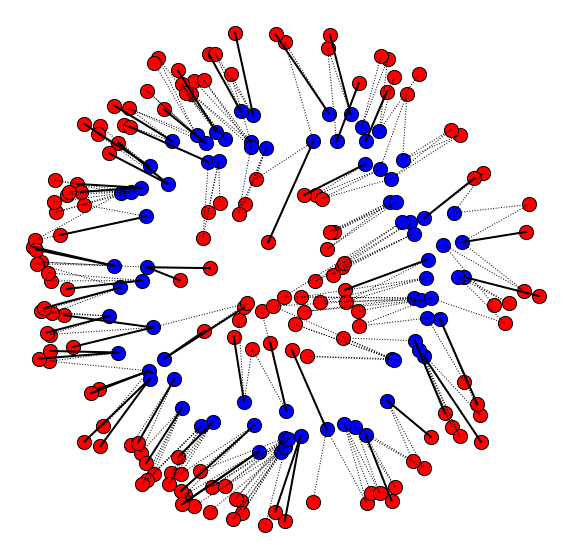

In [20]:
plt.figure(figsize=(10,10))

plotp(x, 'b')
plotp(y, 'r')

A = P * (P > np.max(P)*.9)
i,j = np.where(A != 0)
plt.plot([x[0,i],y[0,j]],[x[1,i],y[1,j]],'k',lw = 2)

A = P * (P > np.max(P)*.2)
i,j = np.where(A != 0)
plt.plot([x[0,i],y[0,j]],[x[1,i],y[1,j]],'k:',lw = 1)

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()

Transport Between Histograms
----------------------------
We now consider a different setup, where the histogram values
$a,b$ are not uniform, but the measures are defined on a uniform grid
$x_i=y_i=i/n$. They are thue often refered to as "histograms".


Size $n$ of the histograms.

In [21]:
N = 100

We use here a 1-D square Euclidean metric.

In [22]:
t = np.arange(0,N)/N

Define the histogram $a,b$ as translated Gaussians.

In [23]:
Gaussian = lambda t0,sigma: np.exp(-(t-t0)**2/(2*sigma**2))
normalize = lambda p: p/np.sum(p)

sigma = .04
a = Gaussian(0.2,sigma)
b = Gaussian(0.8,sigma)

Add some minimal mass and normalize.

In [24]:
vmin = .02
a = normalize(a+np.max(a)*vmin)
b = normalize(b+np.max(b)*vmin)

Display the histograms.

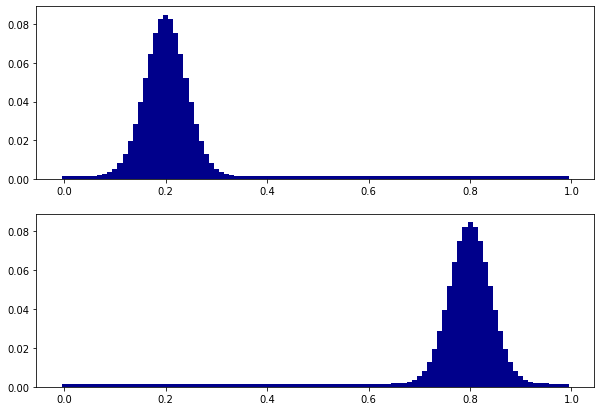

In [25]:
plt.figure(figsize = (10,7))

plt.subplot(2, 1, 1)
plt.bar(t, a, width = 1/len(t), color = "darkblue")
plt.subplot(2, 1, 2)
plt.bar(t, b, width = 1/len(t), color = "darkblue")

plt.show()

Regularization strength $\gamma$.

In [26]:
epsilon = (.03)**2

The Gibbs kernel is a Gaussian convolution,
$$ K_{i,j} := e^{ -(i/N-j/N)^2/\epsilon }. $$

In [27]:
[Y,X] = np.meshgrid(t,t)
K = np.exp(-(X-Y)**2/epsilon)

Initialization of $v=\mathbf{1}_{N}$.

In [28]:
v = np.ones(N)

One sinkhorn iteration.

In [29]:
u = a / (np.dot(K,v))
v = b / (np.dot(np.transpose(K),u))

__Exercise 3__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$ \lVert P \mathbf{1} - a \rVert_1, \lVert P^\top \mathbf{1} - b \rVert_1$. You need to think how to compute it from $(u,v)$.
Display the violation of constraint error in log-plot.

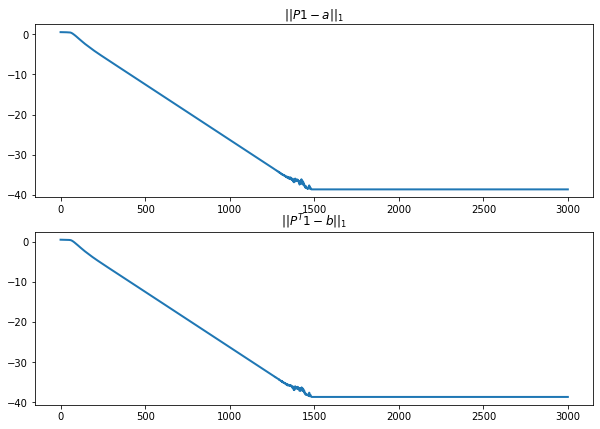

In [30]:
v = np.ones(N)
niter = 3000
Err_p = []
Err_q = []

for i in range(niter):
    # sinkhorn step 1
    u = a / (np.dot(K,v))
    # error computation
    r = v*np.dot(np.transpose(K),u)
    Err_q = Err_q + [linalg.norm(r - b, 1)]
    # sinkhorn step 2
    v = b /(np.dot(np.transpose(K),u))
    s = u*np.dot(K,v)
    Err_p = Err_p + [linalg.norm(s - a,1)]


plt.figure(figsize = (10,7))

plt.subplot(2,1,1)
plt.title("$||P1 -a||_1$")
plt.plot(np.log(np.asarray(Err_p)), linewidth = 2)

plt.subplot(2,1,2)
plt.title("$||P^T 1 -b||_1$")
plt.plot(np.log(np.asarray(Err_q)), linewidth = 2)

plt.show()

Display the coupling. Use a log domain plot to better vizualize it.

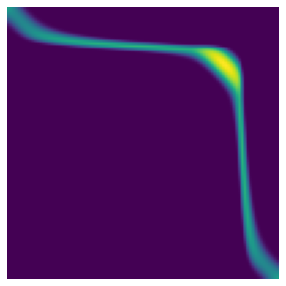

In [31]:
P = np.dot(np.dot(np.diag(u),K),np.diag(v))
plt.figure(figsize=(5,5))
plt.imshow(np.log(P+1e-5))
plt.axis('off');

One can compute an approximation of the transport plan
between the two measure by computing the so-called barycentric projection map
$$ t_i \in [0,1] \longmapsto s_j := \frac{\sum_{j} P_{i,j} t_j }{ \sum_{j} P_{i,j} }
   =  \frac{ [u \odot K(v \odot t)]_j }{ a_i }. $$
where $\odot$ and $\frac{\cdot}{\cdot}$ are the enry-wise multiplication and division.


This computation can thus be done using only multiplication with the
kernel $K$.

In [32]:
s = np.dot(K,v*t)*u/a

Display the transport map, super-imposed over the coupling.

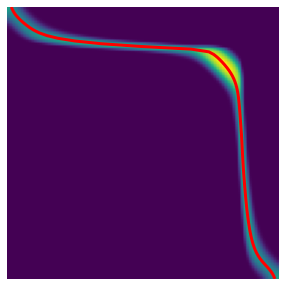

In [33]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(P+1e-5))
plt.plot(s*N,t*N, 'r', linewidth=3);
plt.axis('off');

__Exercise (bonus)__

Try different regularization strength $\epsilon$.

Using GPUs
-----------------------

We will use here [Pytorch](https://pytorch.org/) to implement Sinkhorn on the GPU. If you are running the code on Google Colab, this means you need to switch on in the preferences the use of a GPU.

In [34]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print( device )

cpu


Since CUDA uses float number on 32 bits, one needs to use a quite large value for $\epsilon$ to avoid overflow.

In [35]:
epsilon = (.06)**2
K = np.exp(-(X-Y)**2/epsilon)

Convert Sinkohrn variables and host them on GPU (if available).

In [36]:
u = torch.ones(N)
v = torch.ones(N)
K1 = torch.from_numpy(K).type(torch.FloatTensor); 
a1 = torch.from_numpy(a).type(torch.FloatTensor); 
b1 = torch.from_numpy(b).type(torch.FloatTensor); 
# send them to the GPU
K1 = K1.to(device)
u = u.to(device)
v = v.to(device)
a1 = a1.to(device)
b1 = b1.to(device)

When using Pytorch, it is good practice to implement matrix operation as summation and dummy variables.  We show here how to implement one iteration of Sinkhorn this way.

In [37]:
u = a1 / (K1 * v[None,:]).sum(1)
v = b1 / (K1 * u[:,None]).sum(0)

__Exercise:__

Implement the full algorithm.

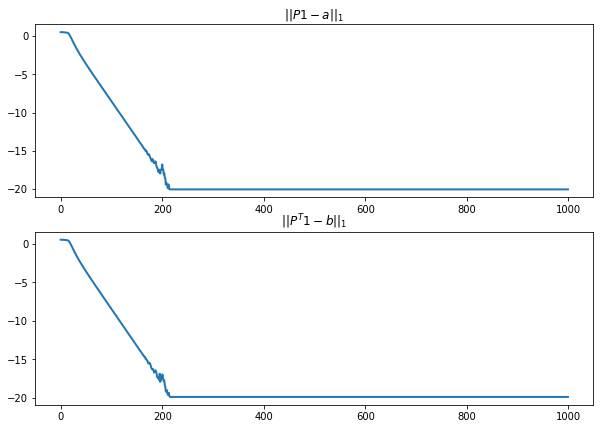

In [38]:
v = torch.ones(N)
niter = 1000
Err_p = torch.zeros(niter)
Err_q = torch.zeros(niter)
for i in range(niter):
    # sinkhorn step 1
    u = a1 / (K1 * v[None,:]).sum(1)    
    # error computation
    r = v*(K1 * u[:,None]).sum(0)
    Err_q[i] = torch.norm(r - b1, p=1)
    # sinkhorn step 2
    v = b1 / (K1 * u[:,None]).sum(0)
    s = u*(K1 * v[None,:]).sum(1)
    Err_p[i] = torch.norm(s - a1,p=1)
plt.figure(figsize = (10,7))
plt.subplot(2,1,1)
plt.title("$||P1 -a||_1$")
plt.plot(np.log(np.asarray(Err_p)), linewidth = 2)
plt.subplot(2,1,2)
plt.title("$||P^T 1 -b||_1$")
plt.plot(np.log(np.asarray(Err_q)), linewidth = 2)
plt.show()

__Exercice__
To avoid underflow, replace the matrix/vector multiplication in a log-sum-exp style, and use the log-sum-exp stabilization trick.

Wasserstein Barycenters
-----------------------
Instead of computing transport, we now turn to the problem of computing
barycenter of $R$ input measures $(a_k)_{k=1}^R$. A barycenter $b$ solves
$$ \min\limits_{b} \sum_{k=1}^R W_\gamma(a_k,b)  $$
where $\lambda_k$ are positive weights with $\sum_k \lambda_k=1$. This
follows the definition of barycenters proposed in
[AguehCarlier](#biblio).

Dimension (width of the images) $N$ of the histograms.

In [39]:
N = 70

You need to install imageio, for instance using
> conda install -c conda-forge imageio

If you need to rescale the image size, you can use
> skimage.transform.resize

Load input histograms $(a_k)_{k=1}^R$, store them in a tensor $A$.

In [40]:
import imageio
rescale = lambda x: (x-x.min())/(x.max()-x.min())
names = ['pause','resume','right-arrow','annulus']
vmin = .01
A = np.zeros([N,N,len(names)])
for i in range(len(names)):
    a = imageio.imread("data/" + names[i] + ".bmp")[:,:,0] # ,N) 
    a = normalize(rescale(a)+vmin)
    A[:,:,i] = a
R = len(names)

Display the input histograms.

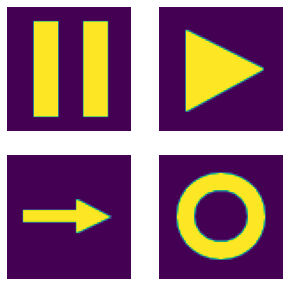

In [41]:
plt.figure(figsize=(5,5))
for i in range(R):
    plt.subplot(2,2,i+1)
    plt.imshow(A[:,:,i])
    plt.axis('off');

In this specific case, the kernel $K$ associated with the
squared Euclidean norm is a convolution with a Gaussian filter
$$ K_{i,j} = e^{ -\lVert i/N-j/N \rVert^2/\epsilon } $$
where here $(i,j)$ are 2-D indexes.


The multiplication against the kernel, i.e. $K(a)$, 
can now be computed efficiently, using fast convolution methods. 
This crucial points was exploited and generalized in [SolomonEtAl](#biblio)
to design fast optimal transport algorithm.

Regularization strength $\epsilon>0$.

In [42]:
epsilon = (.04)**2

Define the $K$ kernel.
We use here the fact that the convolution is separable to implement it
using only 1-D convolution, which further speeds up computations.

In [43]:
t = np.linspace(0,1,N)
[Y,X] = np.meshgrid(t,t)
K1 = np.exp(-(X-Y)**2/epsilon)
K = lambda x: np.dot(np.dot(K1,x),K1)

Display the application of the $K$ kernel on one of the input histogram.

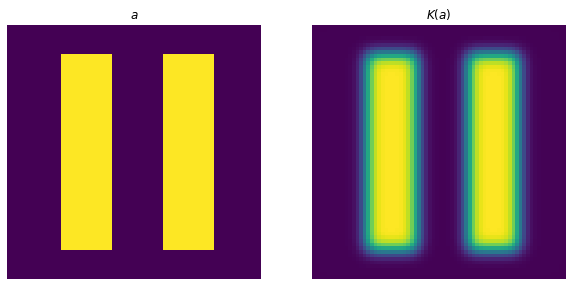

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(A[:,:,0])
plt.title("$a$")
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(K(A[:,:,0]))
plt.title("$K(a)$")
plt.axis('off');

Weights $\lambda_k$ for isobarycenter.

In [45]:
lambd = np.ones(R)/R

It is shown in [BenamouEtAl](#biblio) that the problem of Barycenter computation
boilds down to
optimizing over couplings $(P_k)_{k=1}^R$, and that this can be achieved
using iterative a Sinkhorn-like algorithm, since the optimal coupling has the scaling form
$$P_k = \text{diag}(u_k) K \text{diag}(v_k)$$
for some unknown positive weights $(u_k,v_k)$.

Initialize the scaling factors $(u_k,v_k)_k$, store them in matrices.

In [46]:
v = np.ones([N,N,R])
u = np.copy(v)

The first step of the Bregman projection method corresponds to the
projection on the fixed marginals constraints $P^k \mathbf{1} = a_k$. This
is achieved by updating
$$ \forall k=1,\ldots,R, \quad u_k \longleftarrow \frac{a_k}{ K( v_k ) }. $$

In [47]:
for k in range(R):
    u[:,:,k] = A[:,:,k]/K(v[:,:,k])

The second step of the Bregman projection method corresponds to the
projection on the equal marginals constraints $\forall k, P_k^\top \mathbf{1}=b$ for a common barycenter target $b$. This
is achieved by first computing the target barycenter $b$ using a geometric means
$$ \log(b) := \sum_k \lambda_k \log( u_{k} \odot K ( v_{k} ) ). $$

In [48]:
b = np.zeros(N)
for k in range(R):
    b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(len(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
b = np.exp(b)

Display $b$.

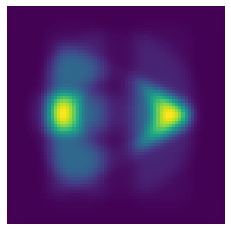

In [49]:
plt.imshow(b);
plt.axis('off');

And then one can update the scaling by a Sinkhorn step using this newly computed histogram $b$ as follow (note that $K=K^\top$ here):
$$ \forall k=1,\ldots,R, \quad v_{k} \longleftarrow \frac{b}{ K(u_{k}) }. $$

In [50]:
for k in range(R):
    v[:,:,k] = b/K(u[:,:,k])

__Exercise 4__

Implement the iterative algorithm to compute the iso-barycenter of the measures.
Plot the decay of the error $\sum_k \lVert P_k \mathbf{1} - a_k \rVert $.

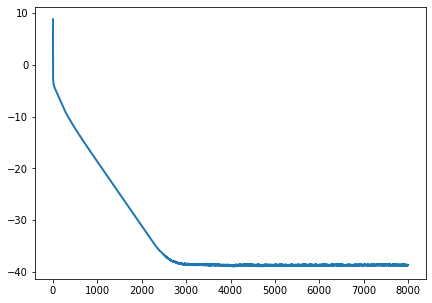

In [51]:
niter = 8000
v = np.ones([N,N,R])
u = np.copy(v)
Err_q = np.zeros(niter)

for i in range(niter):

    for k in range(R):
        Err_q[i] = Err_q[i] + linalg.norm(u[:,:,k]*K(v[:,:,k]) - A[:,:,k], 1)
        u[:,:,k] = A[:,:,k]/K(v[:,:,k])

    b = np.zeros(N)
    for k in range(R):
        b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(len(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
    b = np.exp(b)

    for k in range(R):
        v[:,:,k] = b/K(u[:,:,k])

plt.figure(figsize=(7,5))
plt.plot(np.log(Err_q),linewidth = 2)
plt.show()

Display the barycenter.

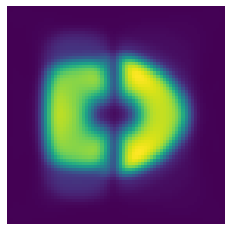

In [52]:
plt.imshow(b)
plt.axis('off');

__Exercise 5__

Compute barycenters for varying weights $\lambda$ corresponding to
a bilinear interpolation inside a square.

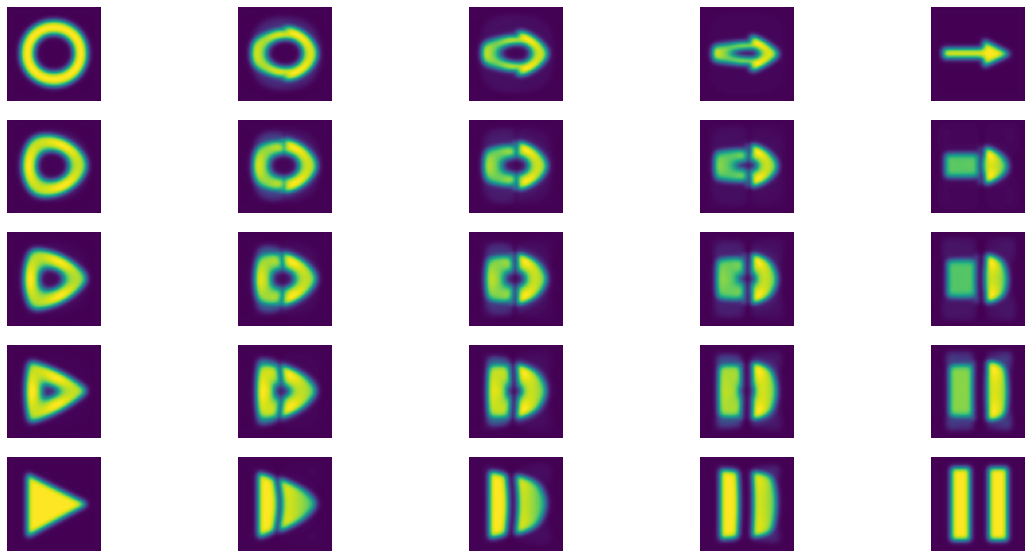

In [53]:
m = 5
[T,S] = np.meshgrid(np.linspace(0,1,m), np.linspace(0,1,m))
T = np.ravel(T,order="F")
S = np.ravel(S,order="F")
niter = 1000

plt.figure(figsize=(20,10))
for j in range(m**2):
    # weights
    lambd = np.hstack((S[j]*T[j], (1-S[j])*T[j], S[j]*(1-T[j]), (1-S[j])*(1-T[j])))
    # computation
    v = np.ones([N,N,R])
    u = np.copy(v)

    for i in range(niter):
        for k in range(R):
            u[:,:,k] = A[:,:,k]/K(v[:,:,k])
        b = np.zeros(N)
        for k in range(R):
            b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(len(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
        b = np.exp(b)
        for k in range(R):
            v[:,:,k] = b/K(u[:,:,k])

    # display
    plt.subplot(m,m,j+1)
    plt.imshow(b)
    plt.axis('off')

Bibliography
------------
<html><a name="biblio"></a></html>


* [Villani] C. Villani, (2009). Optimal transport: old and new, volume 338. Springer Verlag.
* [Cuturi] M. Cuturi, (2013). Sinkhorn distances: Lightspeed computation of optimal transport. In Burges, C. J. C., Bottou, L., Ghahramani, Z., and Weinberger, K. Q., editors, Proc. NIPS, pages 2292-2300.
* [AguehCarlier] M. Agueh, and G Carlier, (2011). Barycenters in the Wasserstein space. SIAM J. on Mathematical Analysis, 43(2):904-924.
* [CuturiDoucet] M. Cuturi and A. Doucet (2014). Fast computation of wasserstein barycenters. In Proc. ICML.
* [BauschkeLewis] H. H. Bauschke and A. S. Lewis. Dykstra's algorithm with Bregman projections: a convergence proof. Optimization, 48(4):409-427, 2000.
* [Sinkhorn] R. Sinkhorn. A relationship between arbitrary positive matrices and doubly stochastic matrices. Ann. Math. Statist., 35:876-879, 1964.
* [SolomonEtAl] J. Solomon, F. de Goes, G. Peyré , M. Cuturi, A. Butscher, A. Nguyen, T. Du, and L. Guibas. Convolutional Wasserstein distances: Efficient optimal transportation on geometric domains. Transaction on Graphics, Proc. SIGGRAPH, 2015.
* [BenamouEtAl] J-D. Benamou, G. Carlier, M. Cuturi, L. Nenna, G. Peyré . Iterative Bregman Projections for Regularized Transportation Problems. SIAM Journal on Scientific Computing, 37(2), pp. A1111-A1138, 2015.